In [ ]:
'''
VIPLAB 비전 네트워크 구조 스터디
2024.03.19 / 2회차
작성자 : 이예준
연락 : dldpwns001@gachon.ac.kr
'''

In [ ]:
## 소스 출처 : torchvision.models.resnet

## Pytorch 기반 네트워크 구조 학습
## 1. stanford40 데이터 셋과 커스텀 모델에 resnet의 코드를 추가하여 성능을 올려봅니다

In [ ]:
# 필요한 라이브러리 로드
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import glob
import pickle
from PIL import Image

**커스텀 데이터 세트 + ResNet**
--------------------------------------------------------------------

In [ ]:
# 커스텀 데이터 세트를 구성하기 위한 Stanford40 데이터 세트를 다운로드하고 압축해제
!wget http://vision.stanford.edu/Datasets/Stanford40.zip
!unzip -qq './Stanford40.zip' -d './Stanford40'

--2024-03-19 09:40:11--  http://vision.stanford.edu/Datasets/Stanford40.zip
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308432833 (294M) [application/zip]
Saving to: ‘Stanford40.zip’

Stanford40.zip      100%[===================>] 294.14M  7.57MB/s    in 30s     

2024-03-19 09:40:42 (9.67 MB/s) - ‘Stanford40.zip’ saved [308432833/308432833]



In [ ]:
## Stanford40 데이터 세트의 구조를 이해해야합니다.
# ./Stanford40/ImageSplits : .txt 파일로 annotation을 진행한 폴더
# ./Stanford40/JPEGImages : 데이터 셋의 이미지가 존재하는 폴더
# ./Stanford40/MatlabAnnotations : .mat 파일로 annotation을 진행한 폴더
# ./Stanford40/XMLAnnotations : .xml 파일로 annotation을 진행한 폴더

# 여기서 우리는 txt 파일로 커스텀 데이터 세트를 만들고 불러오겠습니다.
train_txt_root = '/content/Stanford40/train_set.txt'
test_txt_root = '/content/Stanford40/test_set.txt'

# Stanford40 dataset classes
classes = \
 ['applauding','blowing_bubbles','brushing_teeth','cleaning_the_floor','climbing',
'cooking','cutting_trees','cutting_vegetables','drinking','feeding_a_horse',
'fishing','fixing_a_bike','fixing_a_car','gardening','holding_an_umbrella',
'jumping','looking_through_a_microscope','looking_through_a_telescope','playing_guitar','playing_violin',
'pouring_liquid','pushing_a_cart','reading','phoning','riding_a_bike',
'riding_a_horse','rowing_a_boat','running','shooting_an_arrow','smoking',
'taking_photos','texting_message','throwing_frisby','using_a_computer','walking_the_dog',
'washing_dishes','watching_TV','waving_hands','writing_on_a_board','writing_on_a_book'
]

# 전처리에 대한 자세한 설명은 네트워크 구조 스터디 ppt를 참고해주세요
# 총 두가지 버전으로 전처리를 해봅니다
# .txt 파일로 전처리하기
# .pkl 파일로 전처리하기
if not os.path.isfile(train_txt_root):
  train_link = glob.glob('/content/Stanford40/ImageSplits/*_train.txt')
  train_list = []
  train_label = []
  train_dict = {}

  for txt in train_link:
      with open(txt,'r') as file:
          temp = file.readlines()
          temp_list = []
          for text in temp:
              train_list.append(text[:-1])
  with open(train_txt_root,"w") as train_txt:
    for data_name in train_list:
        for idx, name in enumerate(classes):
          if name == data_name[:-8]:
              train_label.append(idx)
              data = f"{data_name} {idx}\n"
              train_txt.write(data)
              continue
  print('train_set.txt is created')

  train_dict['image_name'] = train_list
  train_dict['label'] = train_label

  with open('/content/Stanford40/train_set.pkl', 'wb') as f:
    pickle.dump(train_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  print('train_set.pkl is created')

if not os.path.isfile(test_txt_root):
  test_link = glob.glob('/content/Stanford40/ImageSplits/*_test.txt')
  test_list = []
  test_label = []
  test_dict = {}

  for txt in test_link:
      with open(txt,'r') as file:
          temp = file.readlines()
          temp_list = []
          for text in temp:
              test_list.append(text[:-1])
  with open(test_txt_root,"w") as test_txt:
    for data_name in test_list:
        for idx, name in enumerate(classes):
          if name == data_name[:-8]:
              test_label.append(idx)
              data = f"{data_name} {idx}\n"
              test_txt.write(data)
              continue
  print('test_set.txt is created')

  test_dict['image_name'] = test_list
  test_dict['label'] = test_label

  with open('/content/Stanford40/test_set.pkl', 'wb') as f:
    pickle.dump(test_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  print('test_set.pkl is created')

train_set.txt is created
train_set.pkl is created
test_set.txt is created
test_set.pkl is created


In [ ]:
root = '/content/Stanford40/train_set.pkl'

with open(root, 'rb') as f:
  data = pickle.load(f)

print(data['image_name'])
print(data['label'])

['taking_photos_125.jpg', 'taking_photos_065.jpg', 'taking_photos_193.jpg', 'taking_photos_173.jpg', 'taking_photos_169.jpg', 'taking_photos_034.jpg', 'taking_photos_151.jpg', 'taking_photos_056.jpg', 'taking_photos_153.jpg', 'taking_photos_083.jpg', 'taking_photos_166.jpg', 'taking_photos_051.jpg', 'taking_photos_128.jpg', 'taking_photos_021.jpg', 'taking_photos_106.jpg', 'taking_photos_174.jpg', 'taking_photos_053.jpg', 'taking_photos_027.jpg', 'taking_photos_023.jpg', 'taking_photos_102.jpg', 'taking_photos_131.jpg', 'taking_photos_194.jpg', 'taking_photos_112.jpg', 'taking_photos_132.jpg', 'taking_photos_087.jpg', 'taking_photos_152.jpg', 'taking_photos_157.jpg', 'taking_photos_032.jpg', 'taking_photos_018.jpg', 'taking_photos_016.jpg', 'taking_photos_165.jpg', 'taking_photos_195.jpg', 'taking_photos_101.jpg', 'taking_photos_103.jpg', 'taking_photos_088.jpg', 'taking_photos_050.jpg', 'taking_photos_121.jpg', 'taking_photos_141.jpg', 'taking_photos_163.jpg', 'taking_photos_081.jpg',

In [ ]:
# 커스텀 데이터 셋을 정의합니다
import torch.utils.data as data
class CustomDataset(data.Dataset):
    # 데이터 셋을 처음 불러올 때 사용되는 __init__ 함수는 데이터 셋을 구성하는데 필요한 요소를 선언하는데 사용됩니다.
    def __init__(self, transform, root):
      super(CustomDataset, self).__init__()

      self.path = '/content/Stanford40/JPEGImages/'
      self.transform = transform

      if 'pkl' in root:
        print('pkl로 데이터를 불러옵니다')
        with open(root, 'rb') as f:
          data = pickle.load(f)

        self.image_name = data['image_name']
        self.label = data['label']
      elif 'txt' in root:
        print('txt로 데이터를 불러옵니다')
        with open(root, 'rb') as f:
          data = f.readlines()
          data_name = []
          data_label = []
          for text in data:
            split = text.split()
            data_name.append(str(split[0].decode("utf-8") ))
            data_label.append(int(split[1].decode("utf-8") ))

        self.image_name = data_name
        self.label = data_label

    # 데이터 셋의 전체 크기를 반환하는 함수
    def __len__(self):
      return len(self.image_name)

    # 데이터 셋이 특정 index에 대해서 데이터를 반환해주는 함수(dataloader에 의해서 관리된다)
    def __getitem__(self, index):
      img = Image.open(self.path+self.image_name[index]).convert('RGB')

      if self.transform is not None:
          img = self.transform(img)

      label = self.label[index]

      return img, label

In [ ]:
# 이미지 처리를 위한 transform을 정의(img to tensor + normalization)
# stanford_train_transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.RandomHorizontalFlip(0.5),
#      transforms.Resize((256,256),antialias=True),
#      transforms.Pad((20,20)),
#      transforms.RandomCrop((224,224)),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

stanford_train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((128,128),antialias=True),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

stanford_test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((128,128),antialias=True),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
## custom dataset을 선언하고 dataloader에 올리기
train_txt_root = '/content/Stanford40/train_set.txt'
train_pkl_root = '/content/Stanford40/train_set.pkl'
test_txt_root = '/content/Stanford40/test_set.txt'
test_pkl_root = '/content/Stanford40/test_set.pkl'


# dataloader 정의에 필요한 batchsize 정의
batch_size = 64

# txt와 pkl를 모두 비교하기 위해서 총 4개의 데이터 세트 및 로더 만들기
train_txt_set = CustomDataset(stanford_train_transform, train_txt_root)
train_pkl_set = CustomDataset(stanford_train_transform, train_pkl_root)
test_txt_set = CustomDataset(stanford_test_transform, test_txt_root)
test_pkl_set = CustomDataset(stanford_test_transform, test_pkl_root)

train_txt_dataloader = torch.utils.data.DataLoader(train_txt_set, batch_size=batch_size, shuffle=True, num_workers=2)
train_pkl_dataloader = torch.utils.data.DataLoader(train_pkl_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_txt_dataloader = torch.utils.data.DataLoader(test_txt_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_pkl_dataloader = torch.utils.data.DataLoader(test_pkl_set, batch_size=batch_size, shuffle=False, num_workers=2)

txt로 데이터를 불러옵니다
pkl로 데이터를 불러옵니다
txt로 데이터를 불러옵니다
pkl로 데이터를 불러옵니다


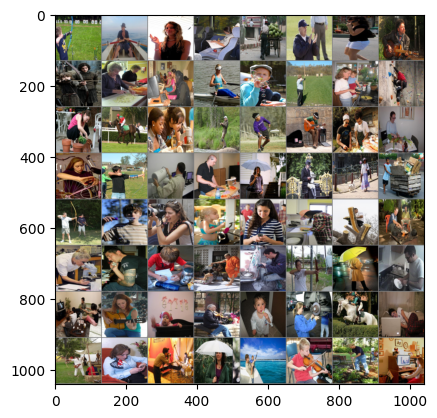

shooting_an_arrow rowing_a_boat smoking writing_on_a_book pushing_a_cart applauding phoning playing_guitar shooting_an_arrow cutting_vegetables using_a_computer rowing_a_boat blowing_bubbles shooting_an_arrow cooking climbing gardening riding_a_horse looking_through_a_microscope fishing throwing_frisby playing_guitar cutting_vegetables cutting_vegetables fixing_a_bike shooting_an_arrow pouring_liquid cutting_vegetables holding_an_umbrella texting_message walking_the_dog pushing_a_cart shooting_an_arrow blowing_bubbles taking_photos blowing_bubbles texting_message cutting_vegetables cutting_trees cooking looking_through_a_microscope phoning writing_on_a_book pouring_liquid fixing_a_car shooting_an_arrow holding_an_umbrella washing_dishes watching_TV playing_guitar waving_hands playing_violin brushing_teeth fixing_a_car riding_a_horse using_a_computer shooting_an_arrow texting_message taking_photos holding_an_umbrella fishing playing_violin gardening using_a_computer


In [ ]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_pkl_dataloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
## ResNet 모듈을 전부 불러옵니다.
## 원래는 torchvision.models에서 모두 선언해서 불러올 수 있지만 눈으로 구조를 확인하기 위해서 선언해줍니다.
import torch
import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url



__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)

    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


In [ ]:
# 모델 불러오고 확인해보기
# my_resnet18 = resnet18(pretrained=False)
my_resnet18 = resnet18(pretrained=True)
last_layer = my_resnet18.fc.weight.shape[1]
my_resnet18.fc = nn.Linear(last_layer, 40)
print(my_resnet18)
net = my_resnet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# resnet 블럭을 만드는 커스텀 함수
def make_my_layer(block, inplanes, planes, blocks, stride=1, dilate=False):
    norm_layer = nn.BatchNorm2d
    downsample = None
    base_width = 64
    if inplanes is not None:
      inplanes = inplanes
    else:
      inplanes = 64
    groups = 1

    if stride != 1 or inplanes != planes * block.expansion:
      downsample = nn.Sequential(
        conv1x1(inplanes, planes * block.expansion, stride),
        norm_layer(planes * block.expansion),
    )

    dilation = 1
    previous_dilation = 1
    if dilate:
        dilation *= stride
        stride = 1
    if stride != 1 or inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            conv1x1(inplanes, planes * block.expansion, stride),
            norm_layer(planes * block.expansion),
        )

    layers = []
    layers.append(block(inplanes, planes, stride, downsample, groups,
                        base_width, previous_dilation, norm_layer))
    inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes, groups=groups,
                            base_width=base_width, dilation=dilation,
                            norm_layer=norm_layer))

    return nn.Sequential(*layers)

# Stanford40 간단한 ResNet 기반 네트워크를 정의
class Stanford_ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = make_my_layer(BasicBlock, 64, 64, 2)
        self.layer2 = make_my_layer(BasicBlock, 64, 128, 4, stride=2)
        self.layer3 = make_my_layer(BasicBlock, 128, 128, 3, stride=2)
        self.layer4 = make_my_layer(BasicBlock, 128, 256, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(4096, 40)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = self.fc1(x)
        return x

In [ ]:
net = Stanford_ResNet()
print(net)

Stanford_ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

In [ ]:
# Loss function, Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00025, momentum=0.9) #여기서 net.parameters()는 'net' 모델에 존재하는 모든 파라미터를 호출하는 함수
#optimizer = optim.AdamW(net.parameters(), lr=0.001) #여기서 net.parameters()는 'net' 모델에 존재하는 모든 파라미터를 호출하는 함수

In [ ]:
# 학습을 진행합니다
epochs = 20

net = net#.cuda()
criterion = criterion#.cuda()

for epoch in range(epochs):   # 데이터셋 학습을 epochs 만큼 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(train_txt_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        #inputs, labels = inputs.cuda(), labels.cuda()

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

    ## 학습된 결과를 확인합니다(전체)
    correct = 0
    total = 0
    # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
    with torch.no_grad():
        for data in test_txt_dataloader:
            images, labels = data

            #images, labels = images.cuda(), labels.cuda()

            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            outputs = net(images)
            # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')

print('Finished Training')

In [ ]:
## 학습된 결과를 확인합니다(전체)

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in test_txt_dataloader:
        images, labels = data

        #images, labels = images.cuda(), labels.cuda()

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
## 학습된 결과를 확인합니다(클래스 별)

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in test_txt_dataloader:
        images, labels = data

        #images, labels = images.cuda(), labels.cuda()

        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')